In [1]:
import kagglehub
adityajn105_flickr30k_path = kagglehub.dataset_download('adityajn105/flickr30k')

print('Data source import complete.')


Using Colab cache for faster access to the 'flickr30k' dataset.
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

In [3]:
def find_image_dir(base_path): # Changed to take base_path
    # Walk through the base_path to find where the images actually are
    for root, dirs, files in os.walk(base_path):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None
IMAGE_DIR = find_image_dir(adityajn105_flickr30k_path) # Use the downloaded path
OUTPUT_FILE = 'flickr30k_features.pkl'
if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")
# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name
# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)
features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)
print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting Features: 100%|██████████| 249/249 [03:11<00:00,  1.30it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


In [4]:
import torch
batch_size = 4
seq_len = 10
image_features = torch.randn(batch_size, 2048)     # real features
captions = torch.randint(0, 10000, (batch_size, seq_len))  # word ids


In [5]:
captions_dict = {}
with open(os.path.join(adityajn105_flickr30k_path, 'captions.txt'), 'r', encoding='utf-8') as f:
    for line in f:
        img, cap = line.strip().split(",", 1)
        captions_dict[img] = cap


print(captions_dict['10002456.jpg'])

 Three men on a large rig .


In [6]:
import os, pickle, random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [7]:
with open('flickr30k_features.pkl', 'rb') as f:
    features = pickle.load(f)

captions_dict = {}
with open(os.path.join(adityajn105_flickr30k_path, 'captions.txt'), 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        img, cap = line.strip().split(",", 1)
        captions_dict.setdefault(img, []).append(cap)


In [8]:
words = []
for caps in captions_dict.values():
    for cap in caps:
        words.extend(['<start>'] + cap.lower().split() + ['<end>'])

freq = Counter(words).most_common(5000)

vocab = {'<pad>': 0}
idx = 1
for w, _ in freq:
    vocab[w] = idx
    idx += 1

vocab['<unk>'] = idx
vocab_size = idx + 1

idx2word = {i: w for w, i in vocab.items()}


In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):
        return torch.tanh(self.fc(x))
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        emb = self.embed(captions[:, :-1])
        x = torch.cat([features.unsqueeze(1), emb], dim=1)
        out, _ = self.lstm(x)
        return self.fc(out)

    def greedy_search(self, features, vocab, max_len=20, repetition_penalty=1.0):
        device = features.device
        batch = features.size(0)
        caps = torch.full((batch, 1), vocab['<start>'], device=device, dtype=torch.long)
        out, state = self.lstm(features.unsqueeze(1))

        for _ in range(max_len):
            emb = self.embed(caps[:, -1:])
            out, state = self.lstm(emb, state)
            logits = self.fc(out[:, -1, :])

            if repetition_penalty != 1.0:
                for i in range(batch):
                    for prev_token in caps[i]:
                         if prev_token.item() == vocab.get('<pad>', 0): continue
                         if logits[i, prev_token] < 0: logits[i, prev_token] *= repetition_penalty
                         else: logits[i, prev_token] /= repetition_penalty

            pred = torch.argmax(logits, dim=1)
            caps = torch.cat([caps, pred.unsqueeze(1)], dim=1)
            if (pred == vocab['<end>']).all(): break
        return caps

    def beam_search(self, feature, vocab, beam=3, max_len=20):
        device = feature.device
        out, state = self.lstm(feature.unsqueeze(1))
        seqs = [[ [vocab['<start>']], 0.0, state ]]

        for _ in range(max_len):
            all_cands = []
            for seq, score, hidden_state in seqs:
                if seq[-1] == vocab['<end>']:
                    all_cands.append([seq, score, hidden_state])
                    continue

                inp = torch.tensor([seq[-1]], device=device).unsqueeze(0)
                emb = self.embed(inp)
                out, new_state = self.lstm(emb, hidden_state)

                logits = self.fc(out[:, -1, :])
                logp = torch.log_softmax(logits, dim=1)
                topk = torch.topk(logp, beam)

                for k in range(beam):
                    cand = seq + [topk.indices[0,k].item()]
                    sc = score + topk.values[0,k].item()
                    all_cands.append([cand, sc, new_state])

            seqs = sorted(all_cands, key=lambda x: x[1], reverse=True)[:beam]
            if all(s[0][-1] == vocab['<end>'] for s in seqs): break

        return seqs[0][0]


In [21]:
class CaptionDataset(Dataset):

    def __init__(self, img_names):
        self.img_names = img_names
        self.max_len = 20

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]

        feat = torch.tensor(features[name], dtype=torch.float32)

        cap = random.choice(captions_dict[name]).lower().split()
        cap = ['<start>'] + cap + ['<end>']

        ids = [vocab.get(w, vocab['<unk>']) for w in cap]

        if len(ids) < self.max_len:
            ids += [vocab['<pad>']] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]

        return feat, torch.tensor(ids)


In [22]:
all_imgs = list(captions_dict.keys())
random.shuffle(all_imgs)

train_imgs = all_imgs[:int(0.8*len(all_imgs))]
val_imgs   = all_imgs[int(0.8*len(all_imgs)):int(0.9*len(all_imgs))]
test_imgs  = all_imgs[int(0.9*len(all_imgs)):]

BATCH_SIZE = 8   # very safe for GPU

train_loader = DataLoader(CaptionDataset(train_imgs), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(CaptionDataset(val_imgs),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(CaptionDataset(test_imgs),  batch_size=BATCH_SIZE)


In [23]:
encoder = Encoder().to(device)
decoder = Decoder(vocab_size=vocab_size, embed_dim=512, hidden_dim=512).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

scaler = GradScaler()


In [24]:
import time
from torch.amp import autocast, GradScaler

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
scaler = GradScaler()

EPOCHS = 5
train_losses, val_losses = [], []

for epoch in range(EPOCHS):

    start = time.time()

    encoder.train()
    decoder.train()

    total = 0

    for imgs, caps in train_loader:

        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            f = encoder(imgs)
            out = decoder(f, caps)

            loss = criterion(
                out[:, :-1, :].reshape(-1, vocab_size),
                caps[:, 1:].reshape(-1)
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total += loss.item()

    train_loss = total / len(train_loader)
    train_losses.append(train_loss)


    encoder.eval()
    decoder.eval()

    vtotal = 0

    with torch.no_grad():
        for imgs, caps in val_loader:

            imgs = imgs.to(device)
            caps = caps.to(device)

            f = encoder(imgs)
            out = decoder(f, caps)

            loss = criterion(
                out[:, :-1, :].reshape(-1, vocab_size),
                caps[:, 1:].reshape(-1)
            )

            vtotal += loss.item()

    val_loss = vtotal / len(val_loader)
    val_losses.append(val_loss)


    train_ppl = np.exp(train_loss)
    val_ppl = np.exp(val_loss)
    t = time.time() - start

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss {train_loss:.4f} | "
        f"Val Loss {val_loss:.4f} | "
        f"Train PPL {train_ppl:.2f} | "
        f"Val PPL {val_ppl:.2f} | "
        f"Time {t:.1f}s"
    )


Epoch 1/5 | Train Loss 4.3661 | Val Loss 4.0619 | Train PPL 78.73 | Val PPL 58.09 | Time 23.9s
Epoch 2/5 | Train Loss 3.9366 | Val Loss 3.9123 | Train PPL 51.24 | Val PPL 50.01 | Time 23.9s
Epoch 3/5 | Train Loss 3.7760 | Val Loss 3.8528 | Train PPL 43.64 | Val PPL 47.13 | Time 24.0s
Epoch 4/5 | Train Loss 3.6757 | Val Loss 3.7999 | Train PPL 39.48 | Val PPL 44.70 | Time 23.8s
Epoch 5/5 | Train Loss 3.5950 | Val Loss 3.7680 | Train PPL 36.41 | Val PPL 43.29 | Time 24.0s


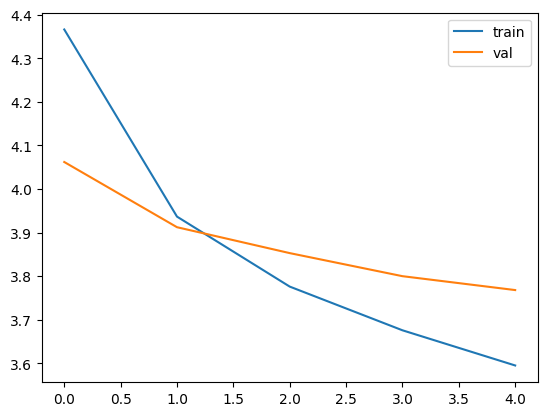

In [25]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.savefig("loss_curve.png")
plt.show()


In [26]:
def tokens_to_words(tokens):
    return [idx2word[t] for t in tokens
            if t not in [vocab['<pad>'], vocab['<start>'], vocab['<end>']]]


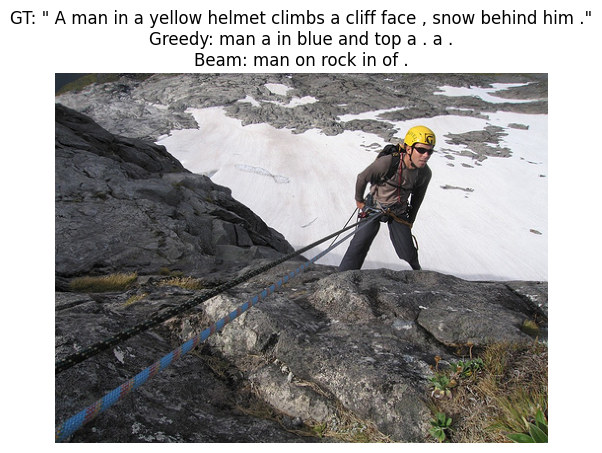

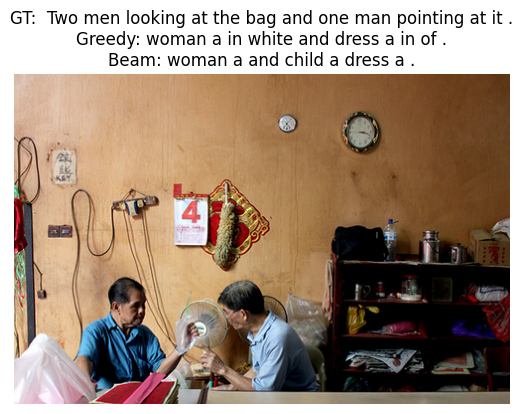

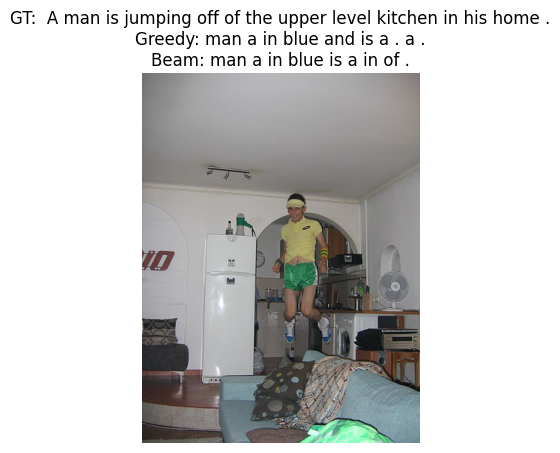

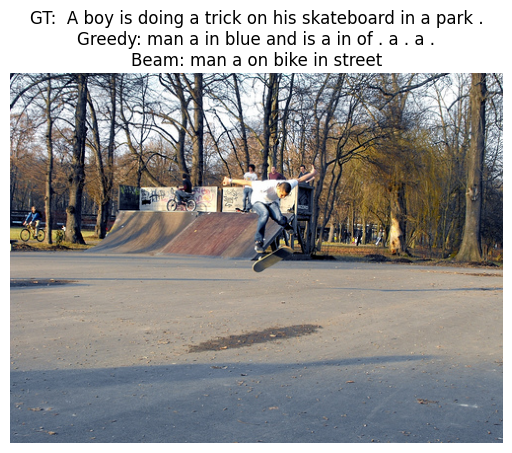

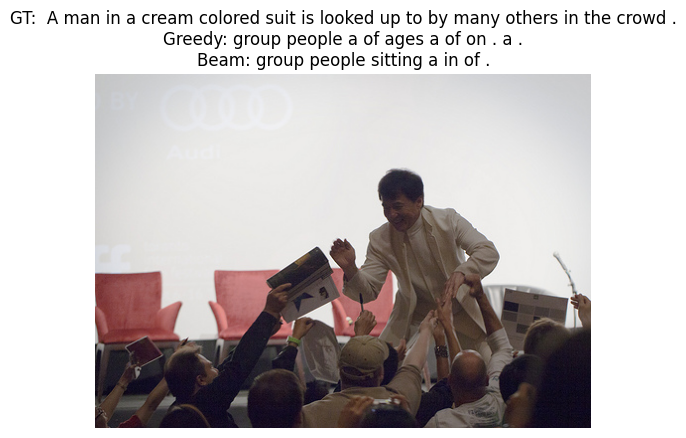

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
import random

# Ensure repetition_penalty_model is imported if not already
# from repetition_penalty_model import LSTMDecoderWithAttention, Decoder

samples = random.sample(test_imgs, 5)

for name in samples:

    img_path = os.path.join(adityajn105_flickr30k_path, "Images", name)
    img = Image.open(img_path)

    feat = torch.tensor(features[name]).unsqueeze(0).to(device)

    f = encoder(feat)

    # UPDATED LINES: Pass 'vocab' to the search functions
    greedy_tokens = decoder.greedy_search(f, vocab)[0].cpu().tolist()
    beam_tokens = decoder.beam_search(f[0:1], vocab)

    greedy_words = " ".join(tokens_to_words(greedy_tokens))
    beam_words = " ".join(tokens_to_words(beam_tokens))

    gt = random.choice(captions_dict[name])

    plt.imshow(img)
    plt.axis("off")
    plt.title("GT: " + gt + "\nGreedy: " + greedy_words + "\nBeam: " + beam_words)
    plt.show()

In [28]:

# --- Export Code for Streamlit ---
import json

# 1. Define paths
ENC_PATH = "encoder.pth"
DEC_PATH = "decoder.pth"
VOCAB_PATH = "vocab.pkl"
CONFIG_PATH = "config.json"

# 2. Save Models
torch.save(encoder.state_dict(), ENC_PATH)
torch.save(decoder.state_dict(), DEC_PATH)
print(f"Saved encoder to {ENC_PATH} and decoder to {DEC_PATH}")

# 3. Save Vocab
with open(VOCAB_PATH, 'wb') as f:
    pickle.dump(vocab, f)
print(f"Saved vocab to {VOCAB_PATH}")

# 4. Save Config
config = {
    'embed_dim': 512,
    'hidden_dim': 512,
    'vocab_size': len(vocab)
}
with open(CONFIG_PATH, 'w') as f:
    json.dump(config, f)
print(f"Saved config to {CONFIG_PATH}")


Saved encoder to encoder.pth and decoder to decoder.pth
Saved vocab to vocab.pkl
Saved config to config.json


In [29]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def calculate_precision_recall_f1(reference_tokens, candidate_tokens):
    # Bag of words (1-gram)
    ref_counts = Counter(reference_tokens)
    cand_counts = Counter(candidate_tokens)

    overlap = sum((ref_counts & cand_counts).values())

    precision = overlap / len(candidate_tokens) if len(candidate_tokens) > 0 else 0
    recall = overlap / sum(ref_counts.values()) if sum(ref_counts.values()) > 0 else 0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def evaluate_model(test_imgs, features_dict, captions_dict, encoder, decoder, vocab, idx2word, beam_size=3):
    bleu4_scores = []
    precisions = []
    recalls = []
    f1s = []

    smooth = SmoothingFunction().method1

    print(f"Evaluating on {len(test_imgs)} test images using Beam Search (k={beam_size})...")

    for name in tqdm(test_imgs):
        # 1. Get Image Features
        feat = torch.tensor(features_dict[name]).unsqueeze(0).to(device)

        # 2. Encode
        with torch.no_grad():
            f = encoder(feat)

        pred_ids = decoder.beam_search(f[0:1], vocab, beam=beam_size)

        pred_words = [idx2word[i] for i in pred_ids if i not in [vocab['<start>'], vocab['<end>'], vocab['<pad>']]]

        references = [cap.lower().split() for cap in captions_dict[name]]

        score = sentence_bleu(references, pred_words, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
        bleu4_scores.append(score)

        local_p, local_r, local_f1 = 0, 0, 0
        for ref in references:
            p, r, f = calculate_precision_recall_f1(ref, pred_words)
            if f > local_f1:
                local_p, local_r, local_f1 = p, r, f

        precisions.append(local_p)
        recalls.append(local_r)
        f1s.append(local_f1)

    print("\n--- Evaluation Results ---")
    print(f"BLEU-4: {np.mean(bleu4_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1-Score: {np.mean(f1s):.4f}")

    return np.mean(bleu4_scores)

evaluate_model(test_imgs[:50], features, captions_dict, encoder, decoder, vocab, idx2word, beam_size=3)


Evaluating on 50 test images using Beam Search (k=3)...


100%|██████████| 50/50 [00:01<00:00, 41.83it/s]


--- Evaluation Results ---
BLEU-4: 0.0403
Precision: 0.5629
Recall: 0.3522
F1-Score: 0.4173


np.float64(0.04032340432159559)

In [33]:
import random
from PIL import Image
import os

# Select two random images from the test set
images_to_export = random.sample(test_imgs, 2)

for i, img_name in enumerate(images_to_export):
    img_path = os.path.join(adityajn105_flickr30k_path, "Images", img_name)
    img = Image.open(img_path).convert('RGB')
    output_filename = f"exported_image_{i+1}_{img_name}"
    img.save(output_filename)
    print(f"Exported {img_name} to {output_filename}")

Exported 3892971736.jpg to exported_image_1_3892971736.jpg
Exported 22930048.jpg to exported_image_2_22930048.jpg
